In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


The goal of this notebook is to get a better understanding of how CNNs work and proper, optimized implementation. In my past few projects, I simply 'tossed' one in with arbitrary values for the dense layers and the architecture was one I found online. Sure, the models got good accuracy but I felt like I didn't know what was going on. I couldn't diagnose errors myself because I didn't understand the network I was writing. 

So Im gonna go through a cnn applied to mnist again, this time I will be laying everything out. I will not leave any stone unturned when it comes to applying and setting up this network.

In [3]:
#so first lets get the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Luckily for me, keras has mnist already and we don't have to load it in ourselves. tf.keras.datasets.mnist.load_data returns two tuples of numpy arrays, training and test data. 

Now lets look at the shape and size of the data:

In [3]:
print(x_train.dtype) #all these are uint8 integers
print(y_train.dtype)
print(x_test.dtype)
print(y_test.dtype)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

uint8
uint8
uint8
uint8
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


So we can see that the input data for both sets is n by 28 by 28 where n is the number of training examples. This is important because we will need to take this into consideration when we implement our CNN.

Also by looking at this, we can see that our labels are n by 1 vectors. We will also take this into consideration when implementing our CNN. Will we have to do some preprocessing to one-hot these labels or will we use a loss function that can handle integer labels? We will talk about that later.

Next, we need to convert the values to floats to be able to do the next step.

One thing that is good practice to do with your data is to normalize it. This means putting it between a range of numbers, like 0 and 1.  We can do this by finding the max value that can occur in the training examples. Because we know that this dataset is greyscale, we can find that the max is 255.  To norm, we have to divide each value by 255. 

In [4]:
#convert to floats
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
#normalize with a handy bit of python shorthand
x_train = x_train / 255.0
x_test = x_test / 255.0
#check the shape and datatypes again
print(x_train.dtype)#float32
print(y_train.dtype)#uint8
print(x_test.dtype)#float32
print(y_test.dtype)#uint8 
#confirm normalization worked
#print(x_train[0][0:10])
#previously the x values would have been integers between 0 and 255 and now they are floats between 0 and 1 

float32
uint8
float32
uint8


It is also a good Idea to see what the data looks like and be able to plot it. We can use the plt.imshow function to do this. We just pass it a single training example, cmap = 'gray' and put plt.show() and it shows it. We can also do it iteratively with a for loop. And we can use subplots to plot a grid of them.

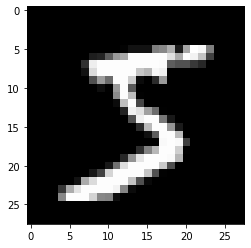

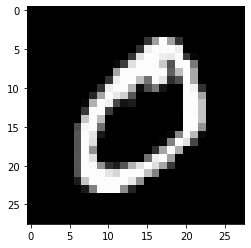

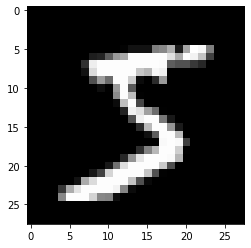

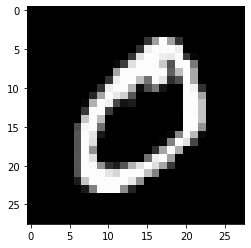

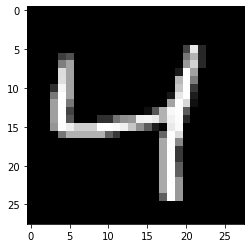

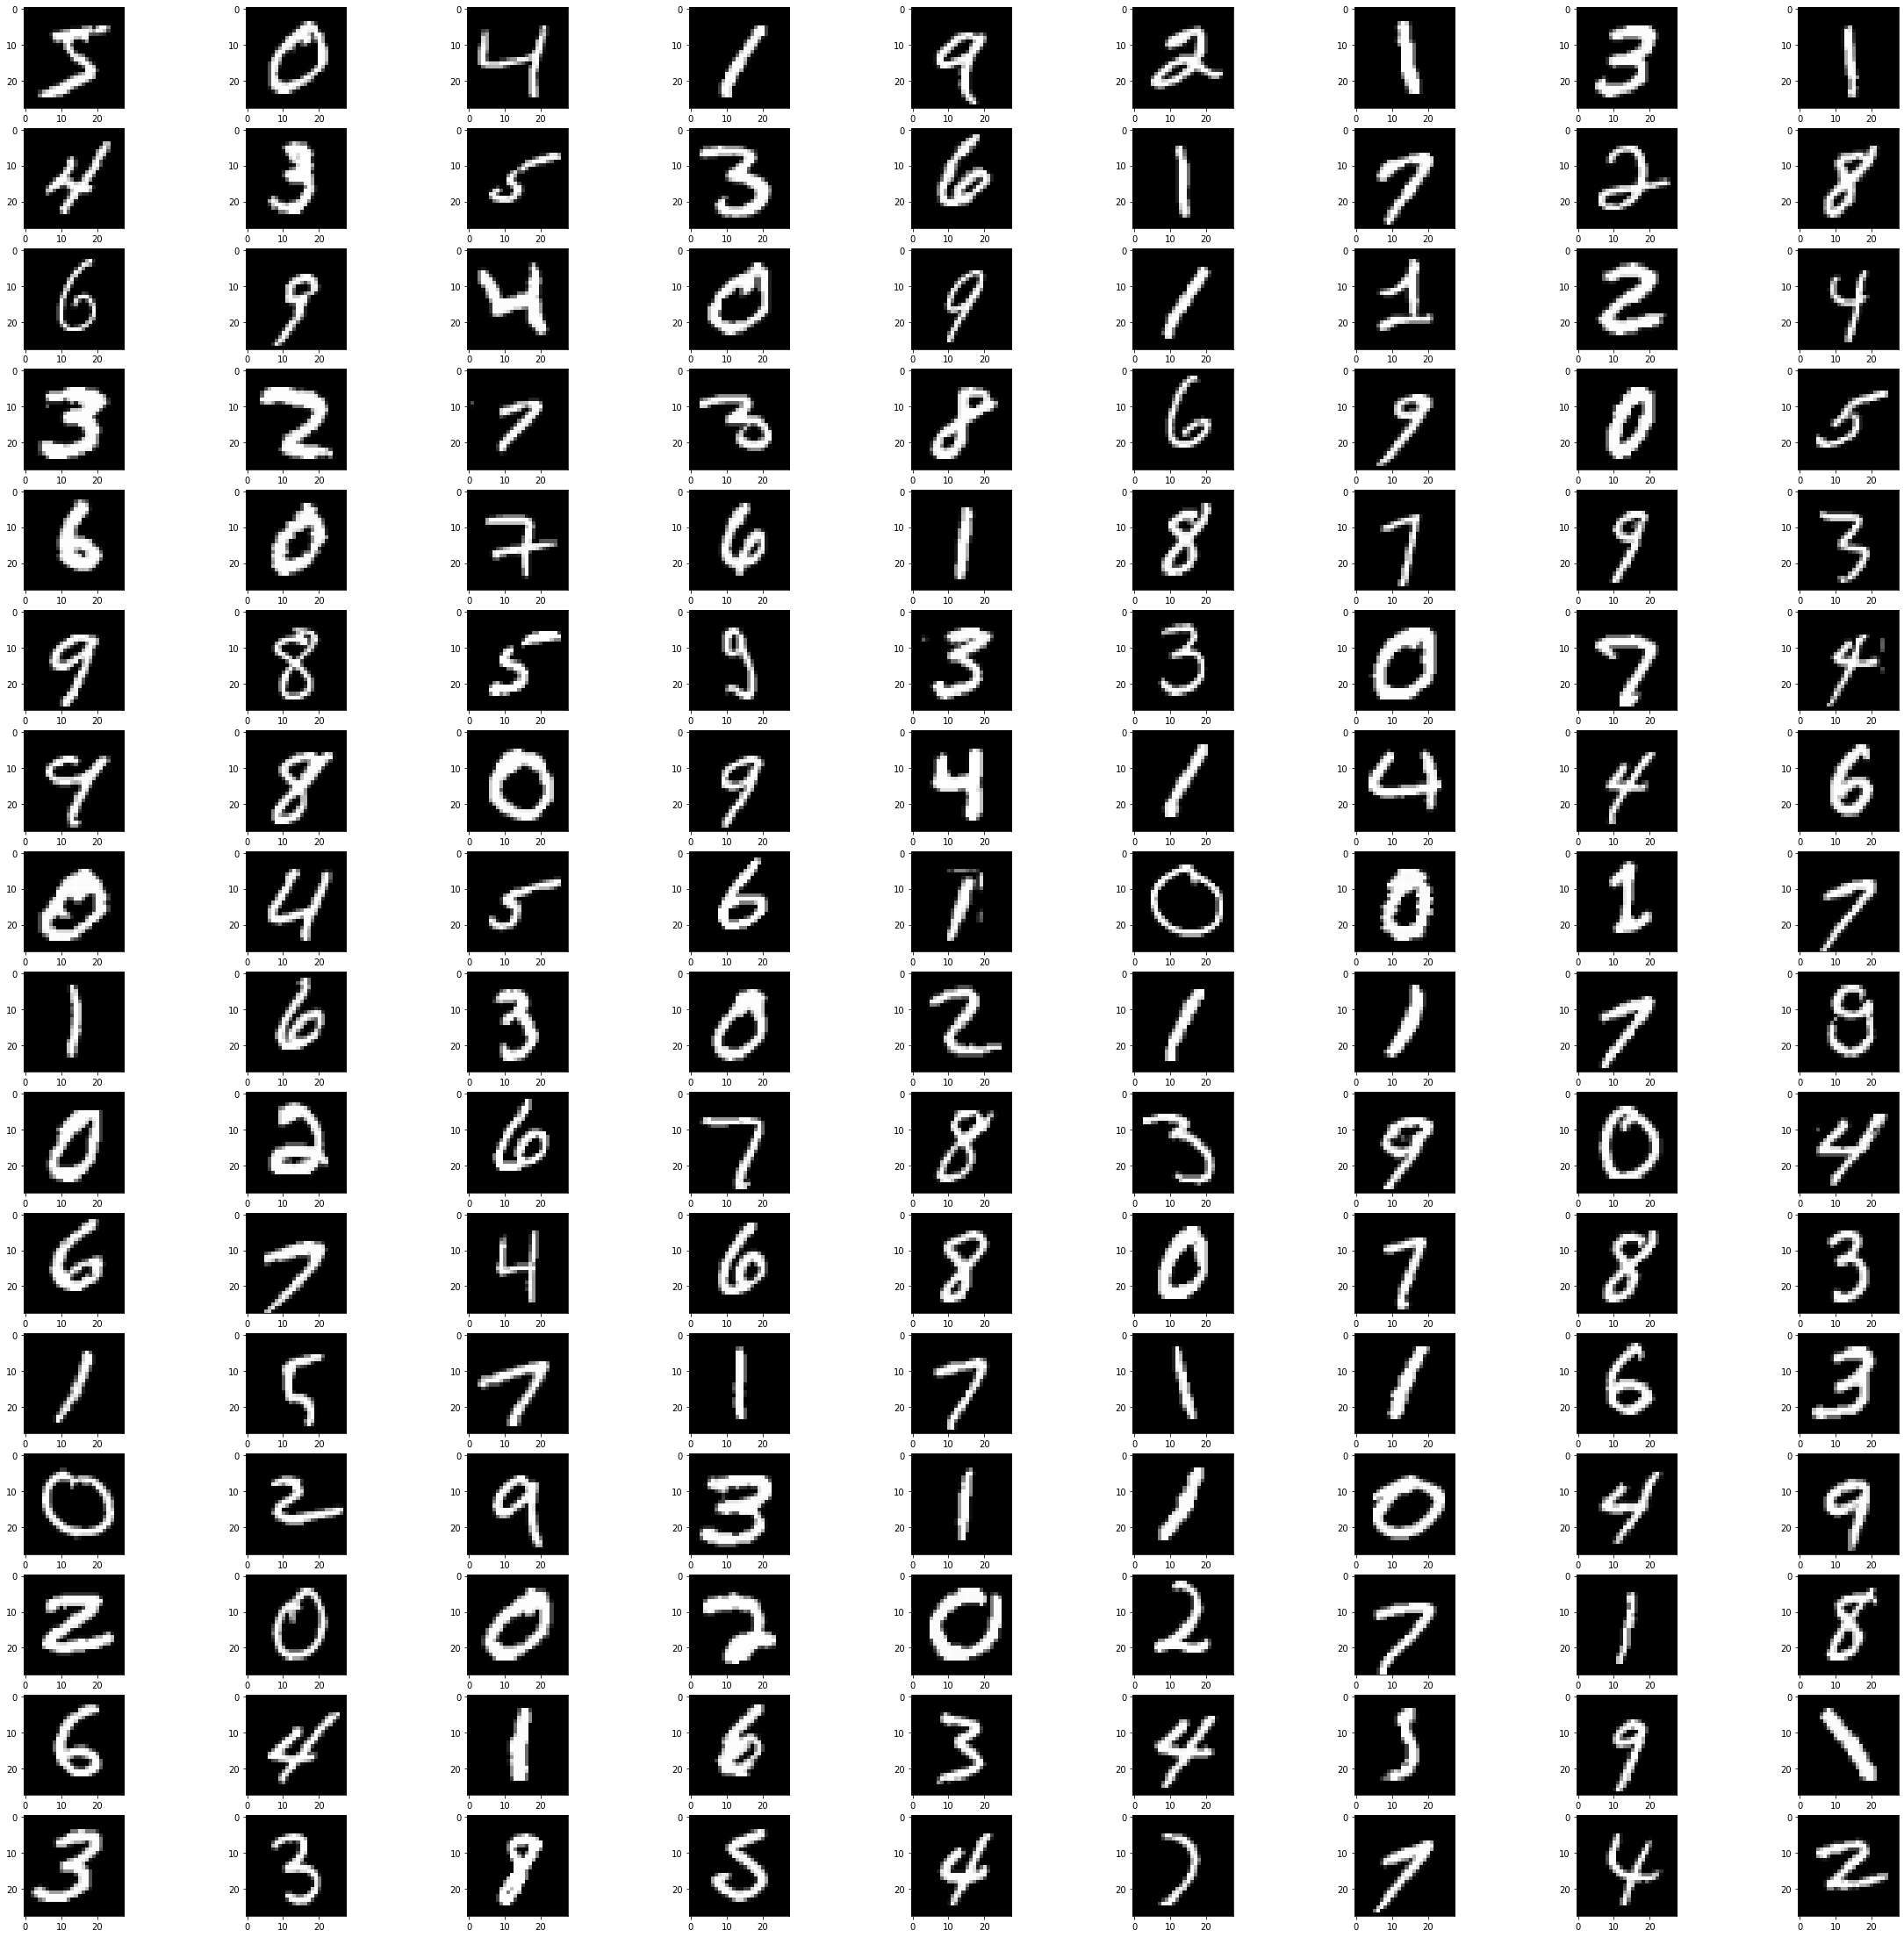

In [5]:
#plot a couple known examples
plt.imshow(x_train[0], cmap ='gray')
plt.show()
plt.imshow(x_train[1], cmap ='gray')
plt.show()
#plot iteratively
for i in range(3):
  plt.imshow(x_train[i], cmap ='gray')
  plt.show()
#plot a grid of given examples
fig , axs = plt.subplots(nrows = 16, ncols = 9, figsize = (40, 40))
#this will show 16 * 9 = 144 examples, but you can play around with the figsize, ncols, and nrows variables to display however many examples you want 

ax = axs.flatten()
for i in range(len(ax)):
    ax[i].imshow(x_train[i], cmap ='gray')
plt.show()


Now is the exciting part, implementation of our CNN.

In [23]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), input_shape = (28, 28, 1), kernel_initializer='he_uniform', activation='relu', padding='same'),
  tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.Dense(10, activation='softmax') 
])



So we make a keras Sequential model with two convolutional layers, a pooling, the feed it into the fully connected model. Lets break it down layer by layer


*   First convolution layer: We define it as having 32 3 x 3 filters on the 28 * 28  input. Recall that a filter makes a feature map by performing an elementwise multiplication on the values it 'slides over'. These filters are how the network learns to see. 
*   The activation, 'relu', is simply if X > 0, return X,  else return 0
*   Padding adds zeros to the input of that layer so that the output of the layer is a certain size. In this example, I used same padding so the output of the convolution layer is the same dimension as the input.
*   This process is repeated for the second convolution layer. 
*   The output of the second layer is then sent to a 2d max pooling layer. What this does is it moves the (2, 2) dimension pooling filter over the ouput of the second convolution layer. We don't set strides explicitly, so it uses the dimensions of the pooling filter. This means that it will move left to right bu two units, and down by two units. Each set of values that it goes over, it finds the max and adds it to its feature map. Because it has stride (2, 2) and padding, it never goes over the same value twice.
*   Therefore, each dimension gets divided by two because it converts 2x2 areas into 1x1 areas. So our 28 by 28 by 32 feature map outputted by our second convolution layer goes through the pooling and becomes a 14 by 14 by 32  feature map. 

*   We then have to feed this output into the fully connected layer. First we need to flatten the input from a 14 by 14 by 32 to a (14 * 14 * 32) by 1 input. This gives us a 6272 by 1 flattened output. This layer is treated as an input layer of a fully connected neural network. Our first dense layer can be thought of as a hidden layer. All the inputs from the flattening connect to all the neurons of the first dense layer. 

*  Again, the activation is relu. This results in n # of hidden outputs, where n is the number of hidden units. Finally, this is fully connected to the final layer, of 10 neurons representing the ten possible numbers. The activation here is softmax, which is reccomended for classification. 

*   Softmax gives probabilities to each output class. These probabilities all add up to one. Compare this to sigmoid, which determines a probability for a class being or not being. For example, sigmoid could predict that an email has a 80 percent chance of being spam and a 20 percent chance of not being spam. Softmax does similar, but only predicts likelihoods of an image belonging to a certain class. Therefore, the output of the network will be the class with the highest probability.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 300)               1881900   
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                        

In [22]:
#can also be implemented like this
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = (28, 28, 1), kernel_initializer='he_uniform', activation='relu', padding='same'))
model2.add(tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation='relu', padding='same'))
model2.add(tf.keras.layers.MaxPool2D((2, 2)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))
model2.summary() # compare here to the above model summary and you can see that it is the same exact model.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_8 (Dense)             (None, 300)               1881900   
                                                                 
 dense_9 (Dense)             (None, 10)                3010      
                                                      

Now that we have defined the model however way we like, we need to compile the model. Compiling the model simply defines the loss function, optimizer, learning rate, and metrics of the model. 

In [24]:
model.compile(optimizer='SGD',  loss='sparse_categorical_crossentropy', metrics=['accuracy'])#default lr is 0.01 with sgd
model2.compile(optimizer='SGD',  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

So we set the optimizer as Stochastic Gradient Descent. By default the learning rate is 0.01. We set the loss as sparse_categorical_crossentropy. This allows us to use integer labels instead of one-hotting them. Finally, we passed in accuracy to the metrics parameter. This will give us the accuracy as well as the loss when we fit the model. During each epoch, a progress bar is shown with training loss and accuracy. After each epoch, validation loss and accuracy will be shown. 

An epoch of training is one pass over the entire dataset. A batch is how many examples it has to go over before it updates weights. We can see that even with our simpler cnn architecture, we see incredible results after even one epoch. 

In [25]:
#fit the models
history = model.fit(x_train, y_train, epochs = 50, validation_split=.2)
history2 = model2.fit(x_train, y_train, epochs = 50, validation_split=.2)

Epoch 1/50
1500/1500 [==============================] - 6s 3ms/step - loss: 0.2723 - accuracy: 0.9172 - val_loss: 0.1310 - val_accuracy: 0.9618
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1148 - accuracy: 0.9654 - val_loss: 0.0945 - val_accuracy: 0.9719
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0764 - accuracy: 0.9772 - val_loss: 0.0719 - val_accuracy: 0.9792
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0575 - accuracy: 0.9833 - val_loss: 0.0656 - val_accuracy: 0.9803
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0454 - accuracy: 0.9860 - val_loss: 0.0639 - val_accuracy: 0.9808
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0356 - accuracy: 0.9899 - val_loss: 0.0587 - val_accuracy: 0.9822
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0301 - accuracy: 0.9910 - val_loss: 0.0507 - val_accuracy:

Above we fit the model by providing training data, a number of epochs, and (optionally) a validation split. Lets explain what each of these do and some best practices


*   Training Data - Pretty self explanatory. Only training data, not test data
*   Epochs - Number of iterations to train for. It is reccomended to train for a smaller number of epochs the first time around so that any mistakes or quick optimizations can be done quickly before a long training session. 
*   Validation Split - This is a percentage of the training data that you want it to use to evaluate your model. It is not used to train, it is used to evaluate. Cross-Validation = Validation. Putting this in will also give you the metrics val_accuracy and val_loss that you can plot to see how your model is performing.

You can also specify a batch size if you want to use a specific one by setting the batch_size parameter. Otherwise it is set to 32 by default.

When this block is executed, both models will be trained for 50 epochs.

Sidenote if you dont want to see the long text block of epoch by epoch performance, you can set verbose = 1. 

Next we need to evaluate the performance of our model or models. We can do this by graphing the accuracy, validation accuracy, loss, and validation loss. Analyzing these curves allow us to see many characteristics of the model. Also we can see the effect of initialization on these metrics. These models are the exact same they just had different initial values. Thats why the curves are different. However, the trends for each model are the same. 

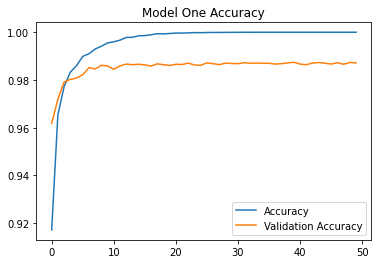

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.title("Model One Accuracy")
plt.show()

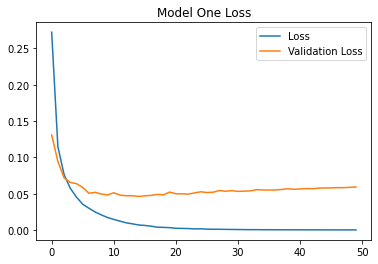

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.title("Model One Loss")
plt.show()

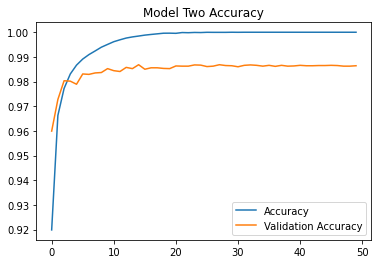

In [28]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.title("Model Two Accuracy")
plt.show()

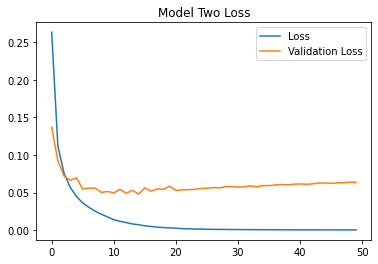

In [29]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.title("Model Two Loss")
plt.show()

To get the accuracy and loss on the test set, we can use the model.evaluate funtion. It is important to remember that training, validation, and test accuracy all changes with initialization. So it is recommended to train multiple times and evaluate those models to get a good idea of the maximum test accuracy that can be achieved using a model of this architecture. 

In [30]:
#Get test metrics for each model 
model.evaluate(x_test, y_test)
model2.evaluate(x_test, y_test)
#both models get around 98.7 percent test accuracy after training for 10 epochs. 
#both models get around 98.89 percent test acuracy after training for 50 epochs

313/313 [==============================] - 1s 3ms/step - loss: 0.0456 - accuracy: 0.9889


[0.04555267095565796, 0.9889000058174133]

Because both models, after 50 epochs of training, get the same accuracy, it is safe to assume that an accuracy of around 98.89 is to be expected. In fact, by looking at both accuracy graphs, the validation accuracy plateaus around that value.